In [30]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

#loading audio files
dog_file = "dog.wav"
gunshot_file = "gunshot.wav"

dog, sr = librosa.load(dog_file)
gun, _ = librosa.load(gunshot_file)

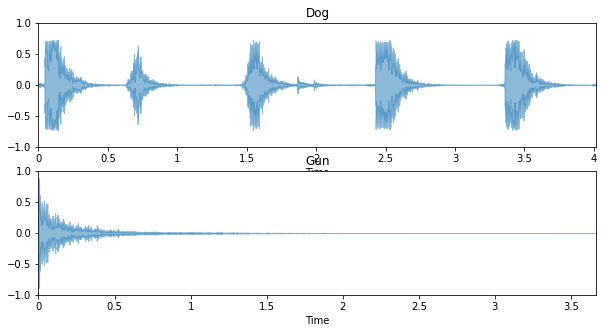

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
librosa.display.waveplot(dog, alpha=0.5)
plt.ylim((-1, 1))
plt.title("Dog")

plt.subplot(2, 1, 2)
librosa.display.waveplot(gun, alpha=0.5)
plt.ylim((-1, 1))
plt.title("Gun")

plt.show()

In [32]:
FRAME_SIZE = 2048
HOP_SIZE = 512

S_dog = librosa.stft(dog, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
S_dog.shape

(1025, 174)

## Calculating the spectrogram

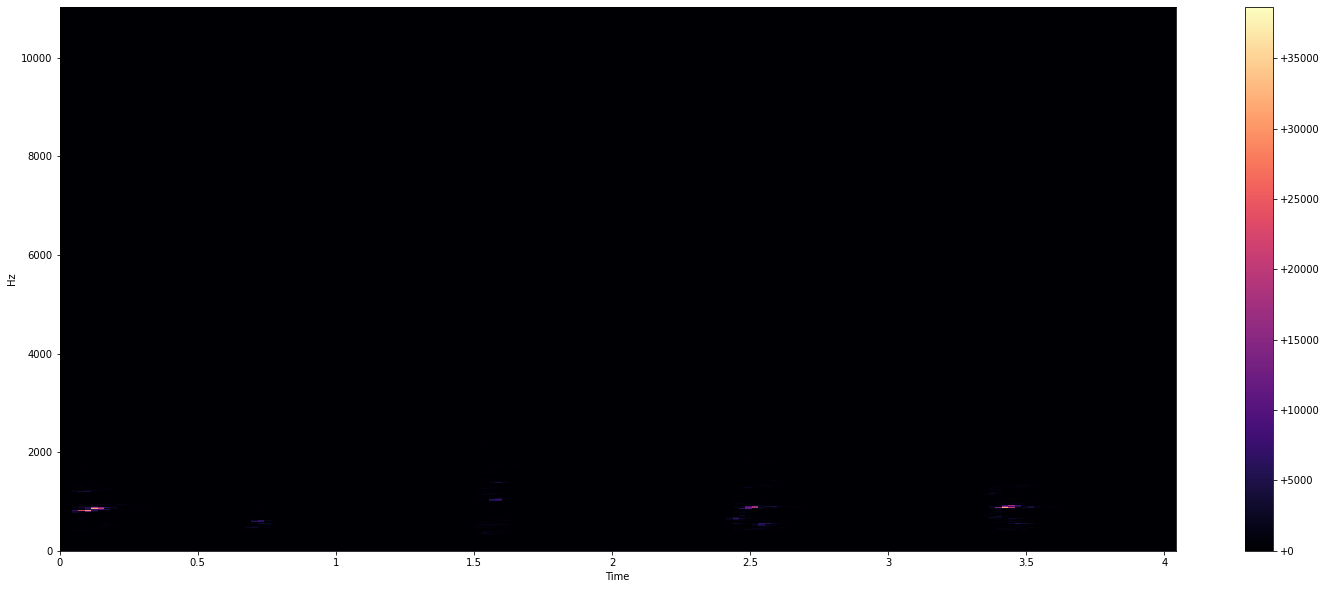

In [33]:
Y_dog = np.abs(S_dog) ** 2

## Visualizing the spectrogram
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    
plot_spectrogram(Y_dog, sr, HOP_SIZE)

## Log-Amplitude Spectrogram

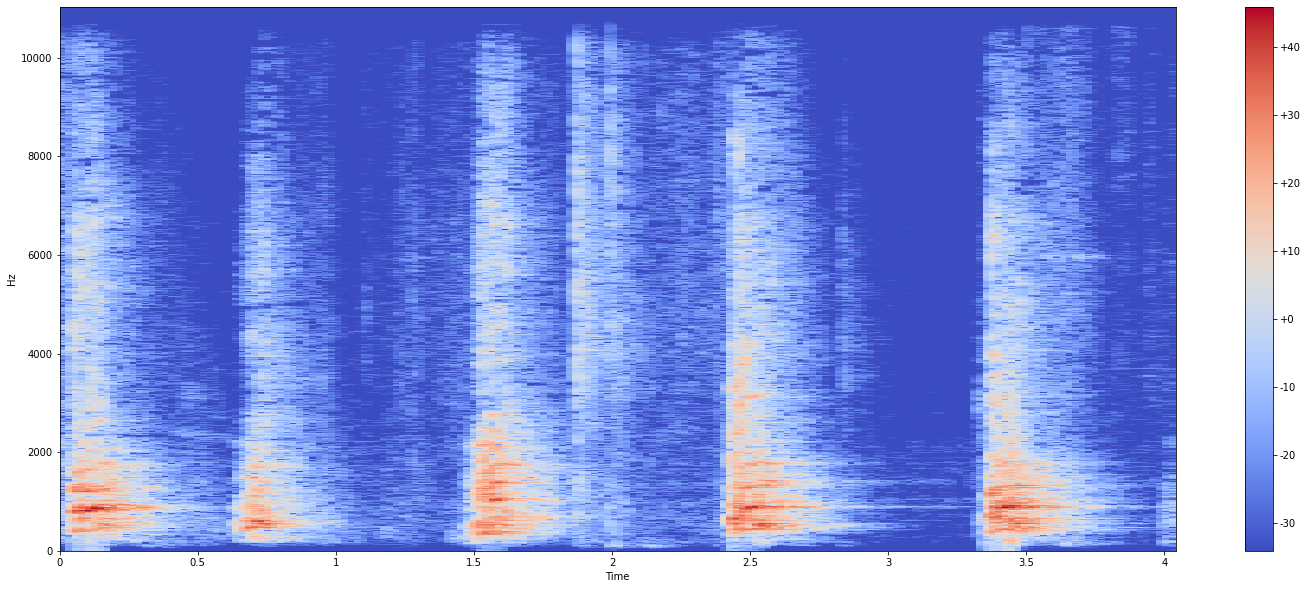

In [34]:
Y_log_scale = librosa.power_to_db(Y_dog)
plot_spectrogram(Y_log_scale, sr, HOP_SIZE)

## Log-Frequency Spectrogram

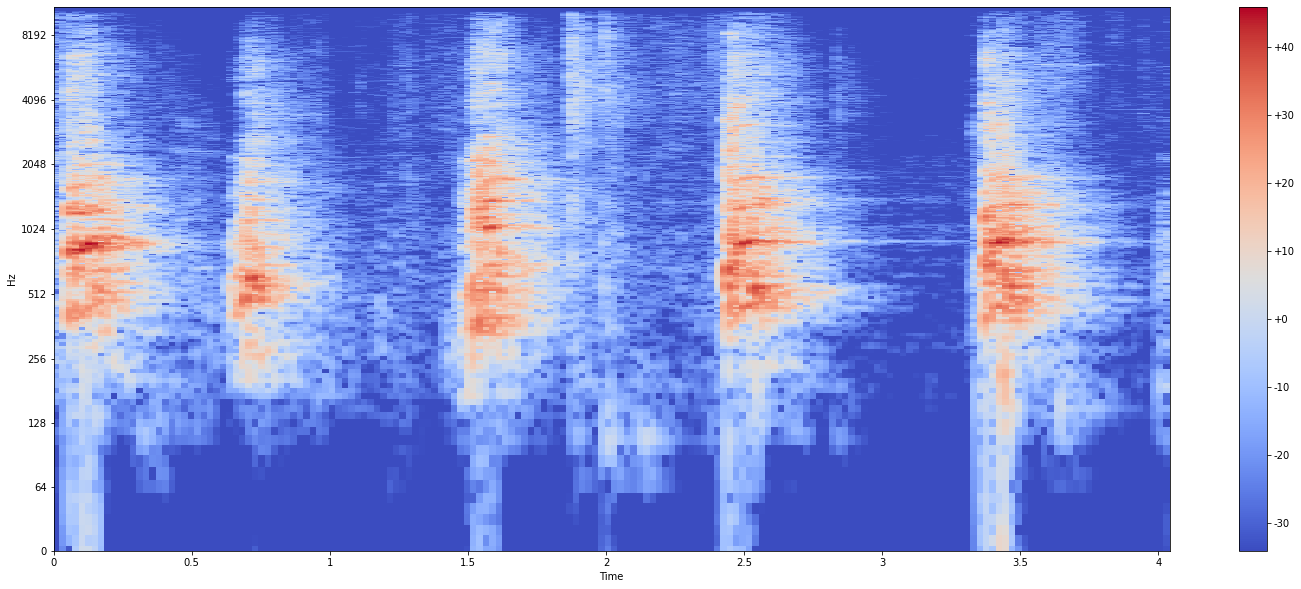

In [35]:
plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")

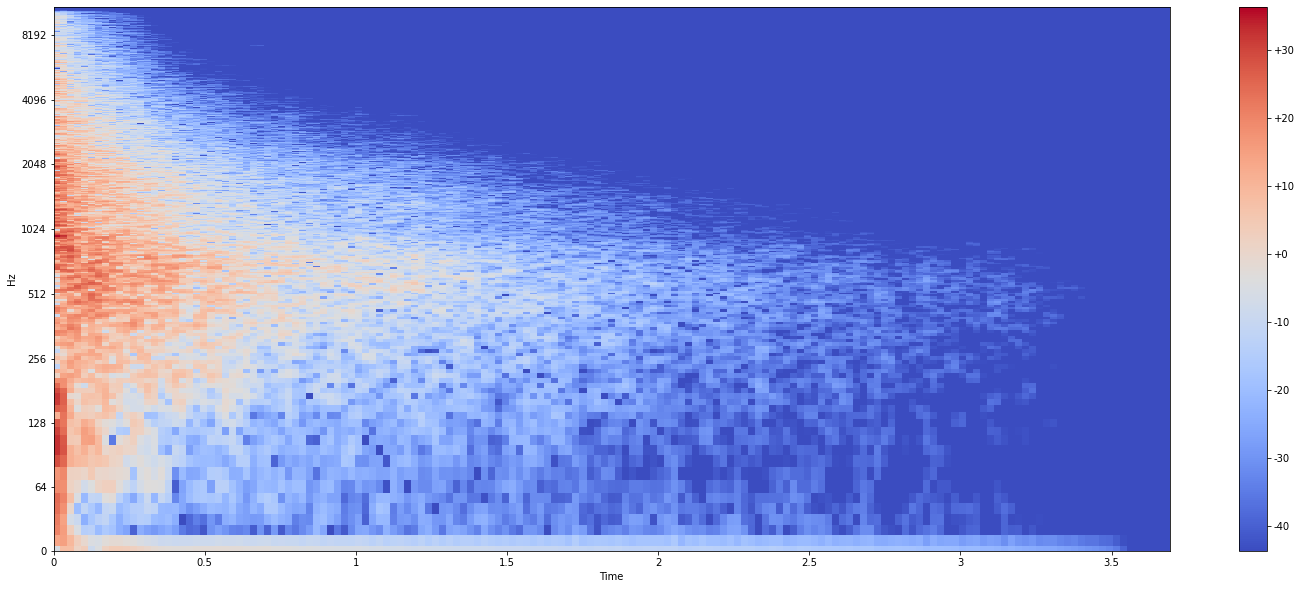

In [36]:
S_gun = librosa.stft(gun, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y_gun = librosa.power_to_db(np.abs(S_gun) ** 2)
plot_spectrogram(Y_gun, sr, HOP_SIZE, y_axis="log")

## Mel filter banks

In [37]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
filter_banks.shape

(10, 1025)

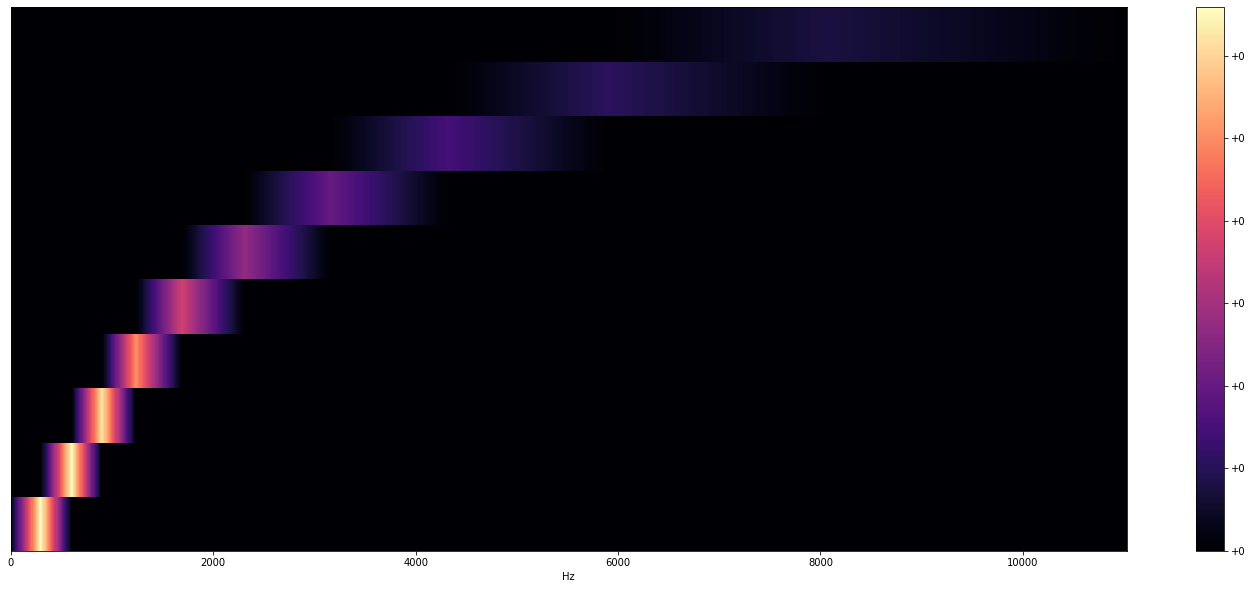

In [38]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

## exctracting mel spectrogram

In [39]:
mel_spectrogram = librosa.feature.melspectrogram(dog, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_spectrogram.shape

(10, 174)

In [40]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape

(10, 174)

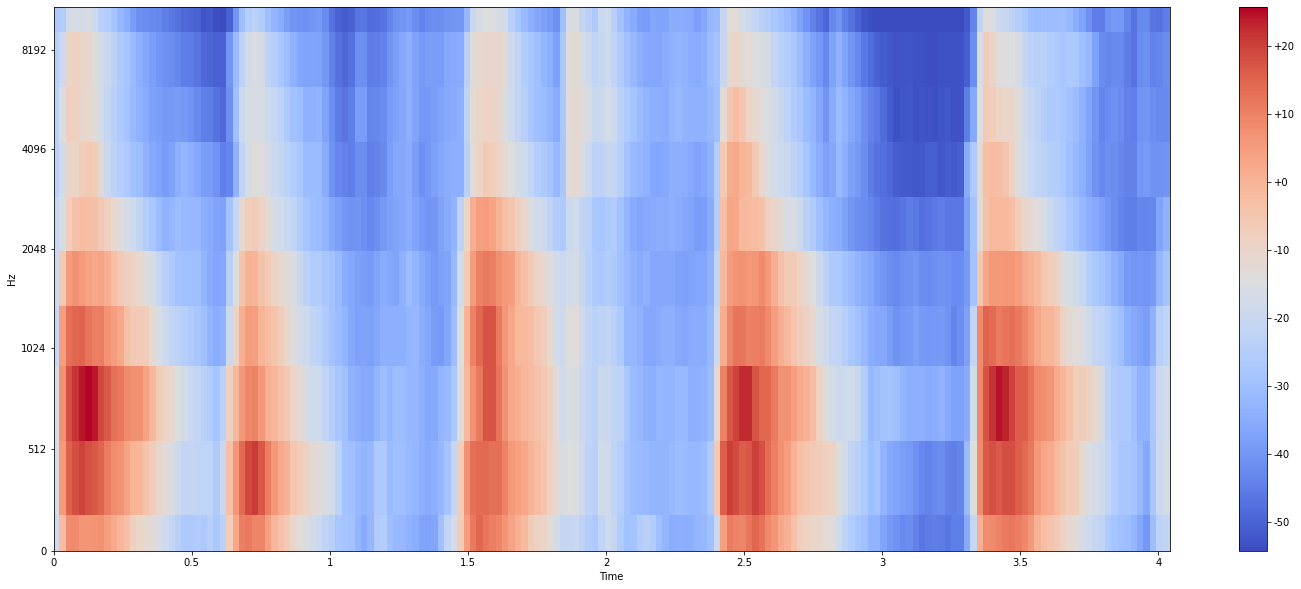

In [41]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

## Band Energy Ratio

In [72]:
import math

def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

split_frequency_bin = calculate_split_frequency_bin(2000, 22050, 1025)
split_frequency_bin

185

In [73]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [74]:
dog_spec = librosa.stft(dog, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
gun_spec = librosa.stft(gun, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

dog_spec.shape

(513, 174)

In [75]:
ber_dog = band_energy_ratio(dog_spec, 2000, sr)
ber_gun = band_energy_ratio(gun_spec, 2000, sr)

C:\Users\HP\anaconda3\envs\siplab\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app


In [70]:
frames = range(len(ber_dog))
t_dog = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
frames = range(len(ber_gun))
t_gun = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

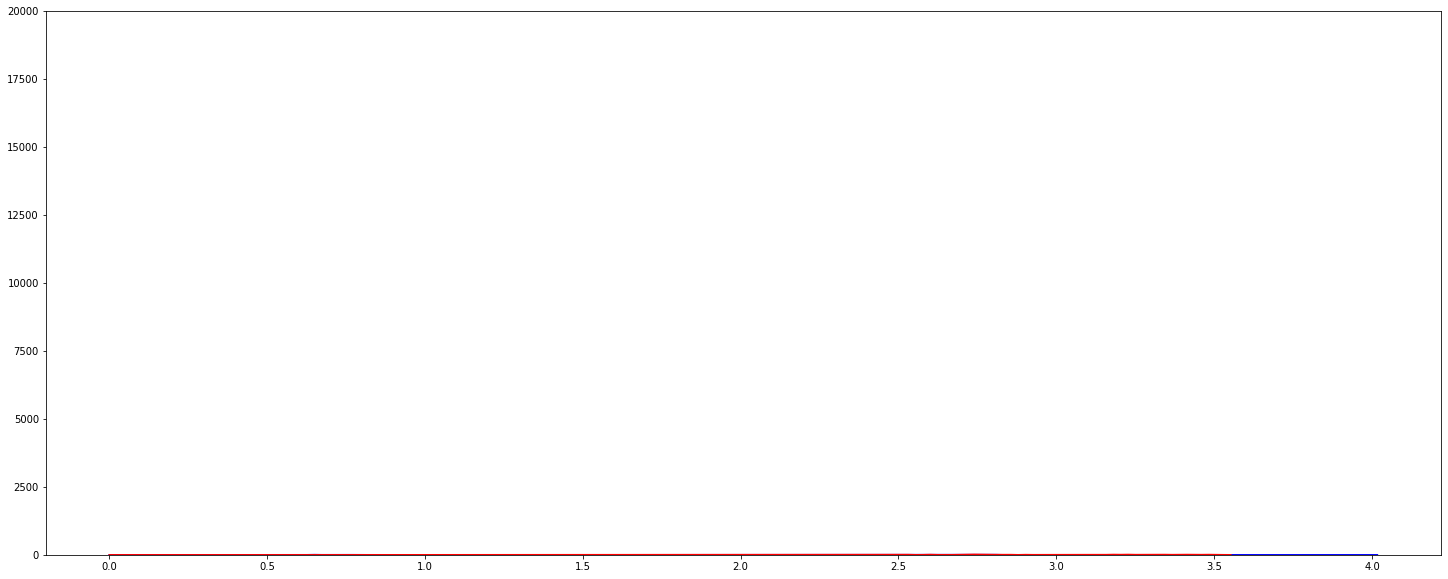

In [71]:
plt.figure(figsize=(25, 10))

plt.plot(t_dog, ber_dog, color="b")
plt.plot(t_gun, ber_gun, color="r")
plt.ylim((0, 20000))
plt.show()

## Spectral Centroid

In [53]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

sc_dog = librosa.feature.spectral_centroid(y=dog, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_gun = librosa.feature.spectral_centroid(y=gun, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

sc_dog.shape
sc_gun.shape

(159,)

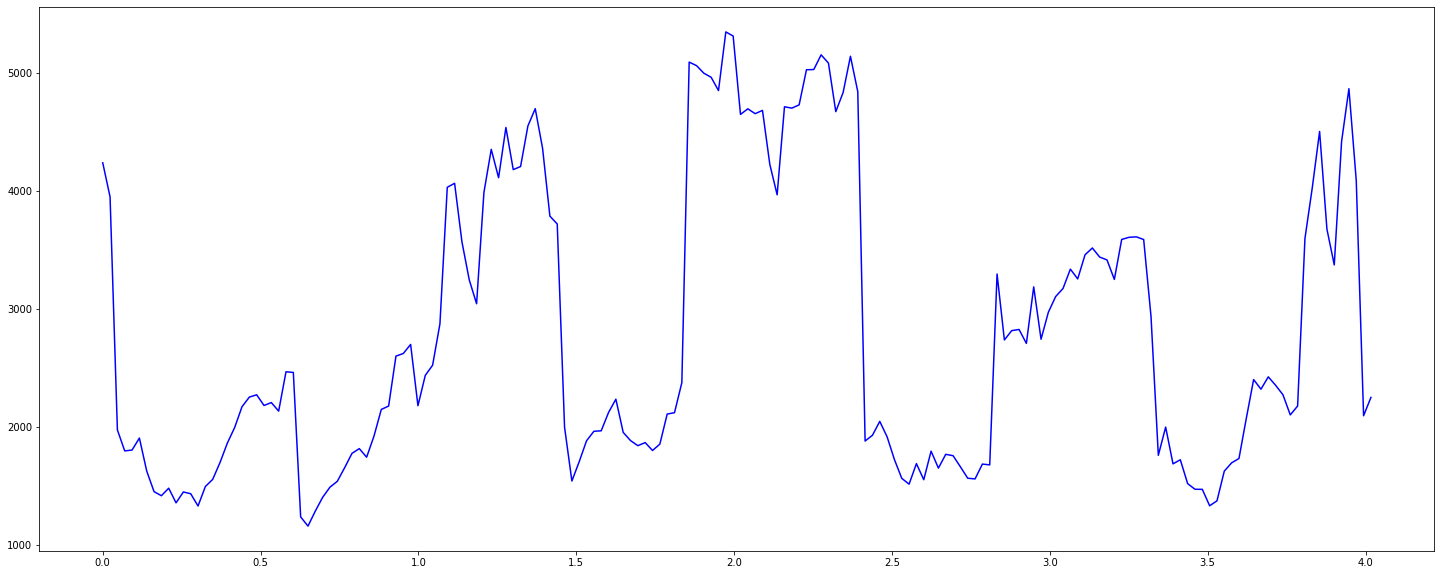

In [60]:
frames = range(len(ber_dog))
t_dog = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
frames = range(len(ber_gun))
t_gun = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

plt.figure(figsize=(25,10))

plt.plot(t_dog, sc_dog, color='b')

plt.show()

## Spectral spread

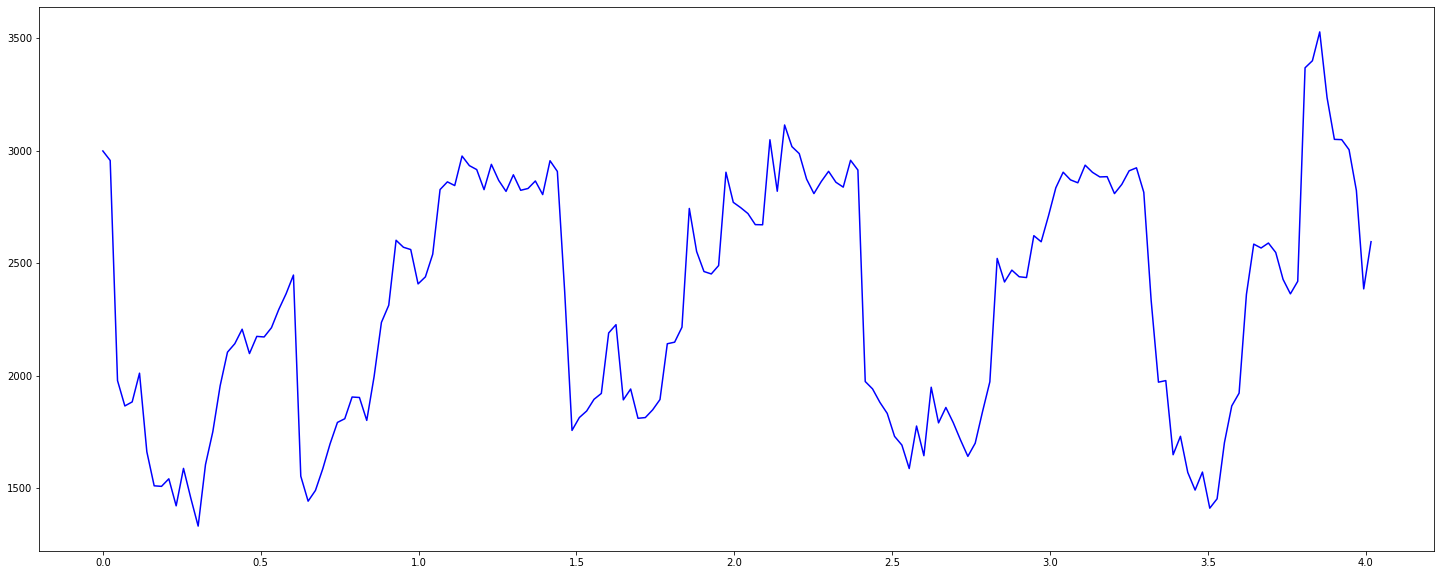

In [63]:
ban_dog = librosa.feature.spectral_bandwidth(y=dog, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
ban_gun = librosa.feature.spectral_bandwidth(y=gun, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

plt.figure(figsize=(25,10))

plt.plot(t_dog, ban_dog, color='b')

plt.show()